In [21]:
import torch
torch.cuda.is_available()

True

## Depth -> pos using camera 

In [22]:
from core.options import AllConfigs 
from core.provider_objaverse import ObjaverseDataset as Dataset
import tyro
import time
import random

import torch
from core.options import AllConfigs
# from core.models import LGM
from core.models_fix_pretrained import LGM
from accelerate import Accelerator, DistributedDataParallelKwargs
from safetensors.torch import load_file

import kiui

from ipdb import set_trace as st
import os
import json
import re
import glob 
import shutil
from tqdm import tqdm
import numpy as np
import sys



In [23]:


data_path="/mnt/kostas-graid/sw/envs/chenwang/workspace/lrm-zero123/assets/9000-9999"
scene_name_pattern = os.path.join(data_path, '*')
scene_dirs = sorted(glob.glob(scene_name_pattern))
for i, scene_path in enumerate(scene_dirs):
    if i > 3:
        break
    scene_name = scene_path.split('/')[-2] if scene_path.endswith('/') else scene_path.split('/')[-1]
    print(scene_name)


0047fa5e44334d3e9bd171ad2bf95ff5
00e90648c8b94d0b9ea8a92858bd8e73
0121bb935b0641bf9733b41be191e5b5
01529e7c8d7842c498f28a9d5927a0d6


In [24]:


 # Filter out the --f argument if it's passed
filtered_args = ["big"]
# filtered_args += [arg for arg in sys.argv if not arg.startswith('--f=')]
# print(filtered_args)

opt = tyro.cli(AllConfigs, args=filtered_args)
# print(opt)

 # training 
train_dataset = Dataset(opt, name=scene_path, training=True)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=opt.batch_size,
    shuffle=False,
    # num_workers=opt.num_workers,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
)

In [25]:

for i, data in enumerate(train_dataloader):
    if i > 1 :
        break
    print(data.keys())
    print(data['cam_pos'].shape)
    print(data['cam_view'].shape)

    # use cam pos for projection
    print(data['cam_view_proj'])


dict_keys(['images_output', 'masks_output', 'input', 'c2w_colmap', 'cam_view', 'cam_view_proj', 'cam_pos', 'vids'])
torch.Size([1, 8, 3])
torch.Size([1, 8, 4, 4])
tensor([[[[ 2.1892e+00, -1.6311e-08, -2.2352e-08, -1.4901e-08],
          [-4.8611e-16, -2.1892e+00,  4.4703e-08,  2.9802e-08],
          [ 1.6311e-08, -4.0778e-09, -1.5000e+00, -1.0000e+00],
          [ 8.1555e-09,  1.3049e-07,  1.6250e+00,  1.5000e+00]],

         [[ 1.0946e+00, -6.4845e-01, -1.2207e+00, -8.1380e-01],
          [ 9.4797e-01, -1.5944e+00,  7.9668e-01,  5.3112e-01],
          [-1.6419e+00, -1.3528e+00, -3.5383e-01, -2.3589e-01],
          [ 1.2145e-07, -1.1231e-07,  1.6250e+00,  1.5000e+00]],

         [[-1.0946e+00,  9.4797e-01, -1.1250e+00, -7.5000e-01],
          [ 9.4797e-01, -1.3683e+00, -9.7428e-01, -6.4952e-01],
          [-1.6419e+00, -1.4219e+00,  1.8750e-01,  1.2500e-01],
          [-1.9485e-07,  2.6984e-08,  1.6250e+00,  1.5000e+00]],

         [[-2.1892e+00, -2.1728e-08,  2.0072e-08,  1.3381e-08],

In [26]:
cam_index = 2
cam_view = data['cam_view'][:,cam_index] # choose one cam
cam_poses = data['c2w'][:,cam_index] # choose one cam
cam_view.shape, cam_poses.shape
# cam_poses[:, :3, 1:3] *= -1
cam_poses_neg = cam_poses.clone()
cam_poses_neg[:, :3, 1:3] *= -1

cam_view2 = torch.inverse(cam_poses).transpose(1, 2)
cam_view3 = torch.inverse(cam_poses_neg).transpose(1, 2)
torch.allclose(cam_view, cam_view2), torch.allclose(cam_view, cam_view3)


KeyError: 'c2w'

In [ ]:
# check whether bmm is the same as @ 
N=20
# c2w = cam_poses
c2w = cam_poses_opengl
pos = torch.rand(1,N,3)
cam_pos = torch.cat([pos,
           torch.ones((pos.shape[0], pos.shape[1], 1), device=c2w.device, dtype=torch.float32)
            ], dim=2)
pos_bmm = torch.bmm(cam_pos, c2w)
pos_bmm_transpose = torch.bmm(cam_pos, c2w.transpose(1,2))
pos_at = pos @ c2w[:, :3, :3].transpose(1,2) + c2w[:, :3, 3]
pos_left = (c2w @ cam_pos.transpose(1,2)).transpose(1,2) # pos_at = pos_left = pos_bmm_transpose
# 

In [ ]:
pos_left = pos_left[...,:3] / pos_left[...,3:]
pos_left

tensor([[[ 0.2636,  0.5374, -0.9958],
         [ 0.7844,  0.7497, -0.4034],
         [ 0.8524,  0.8188, -0.3720],
         [ 0.4813,  0.3158, -1.3217],
         [ 0.7257,  0.8833, -1.2464],
         [ 1.0317,  0.7303, -0.8191],
         [ 1.0091,  0.4057, -0.9643],
         [ 0.6679,  1.0131, -1.0509],
         [ 1.2794,  0.3741, -1.0124],
         [ 0.4214,  1.2213, -0.8997],
         [ 1.0915,  0.6375, -0.9008],
         [ 0.3917,  0.3427, -1.2015],
         [ 0.3986,  0.2596, -1.4174],
         [ 1.2430,  0.5930, -1.1235],
         [ 0.0647,  0.5999, -0.6749],
         [ 1.1825,  0.6687, -1.1637],
         [ 0.2545,  0.4493, -1.0544],
         [ 0.7765,  0.8034, -0.8130],
         [ 1.1174,  0.4089, -1.1132],
         [ 0.4144,  0.4043, -0.6416]]])

In [ ]:

# pos_bmm = pos_bmm[...,:3] / pos_bmm[...,3:]
# pos_bmm_transpose = pos_bmm_transpose[...,:3] / pos_bmm_transpose[...,3:]
pos_bmm, 
pos_bmm_transpose

tensor([[[ 0.2636,  0.5374, -0.9958],
         [ 0.7844,  0.7497, -0.4034],
         [ 0.8524,  0.8188, -0.3720],
         [ 0.4813,  0.3158, -1.3217],
         [ 0.7257,  0.8833, -1.2464],
         [ 1.0317,  0.7303, -0.8191],
         [ 1.0091,  0.4057, -0.9643],
         [ 0.6679,  1.0131, -1.0509],
         [ 1.2794,  0.3741, -1.0124],
         [ 0.4214,  1.2213, -0.8997],
         [ 1.0915,  0.6375, -0.9008],
         [ 0.3917,  0.3427, -1.2015],
         [ 0.3986,  0.2596, -1.4174],
         [ 1.2430,  0.5930, -1.1235],
         [ 0.0647,  0.5999, -0.6749],
         [ 1.1825,  0.6687, -1.1637],
         [ 0.2545,  0.4493, -1.0544],
         [ 0.7765,  0.8034, -0.8130],
         [ 1.1174,  0.4089, -1.1132],
         [ 0.4144,  0.4043, -0.6416]]])

In [ ]:
pos_at

tensor([[[ 0.2636,  0.5374, -0.9958],
         [ 0.7844,  0.7497, -0.4034],
         [ 0.8524,  0.8188, -0.3720],
         [ 0.4813,  0.3158, -1.3217],
         [ 0.7257,  0.8833, -1.2464],
         [ 1.0317,  0.7303, -0.8191],
         [ 1.0091,  0.4057, -0.9643],
         [ 0.6679,  1.0131, -1.0509],
         [ 1.2794,  0.3741, -1.0124],
         [ 0.4214,  1.2213, -0.8997],
         [ 1.0915,  0.6375, -0.9008],
         [ 0.3917,  0.3427, -1.2015],
         [ 0.3986,  0.2596, -1.4174],
         [ 1.2430,  0.5930, -1.1235],
         [ 0.0647,  0.5999, -0.6749],
         [ 1.1825,  0.6687, -1.1637],
         [ 0.2545,  0.4493, -1.0544],
         [ 0.7765,  0.8034, -0.8130],
         [ 1.1174,  0.4089, -1.1132],
         [ 0.4144,  0.4043, -0.6416]]])

In [ ]:
torch.allclose(pos_at, pos_left), torch.allclose(pos_at, pos_bmm_transpose), torch.allclose(pos_bmm, pos_left)

(True, True, False)

### check the einops consistency

In [ ]:

import einops

In [ ]:
B,V,H,W = 1, 6, 128, 128
depth = torch.rand([B,V,1,H,W])
depth_copy = depth.clone()
print(depth.shape)
depth = einops.rearrange(depth, 'b v c h w-> (b v) (h w) c', v=V, h=H, w=W)
depth = einops.rearrange(depth, '(b v) (h w) c-> b v c h w', v=V, h=H, w=W)

torch.allclose(depth_copy, depth)

torch.Size([1, 6, 1, 128, 128])


/mnt/kostas-graid/sw/envs/xuyimeng/anaconda3/envs/lgm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

### Verify the depth_act used in the splatter image

In [ ]:

import torch

In [ ]:
depth = torch.rand(6,213,2)*10
depth, torch.sigmoid(depth), torch.logit(torch.sigmoid(depth)), \
torch.allclose(depth,  torch.logit(torch.sigmoid(depth)))

### Save a vis of depth

In [ ]:
import torch
import kiui

In [ ]:
# read ply
# Load the tensor from the file
# file_path = 'runs/LGM_optimize_splatter/debug2/00013-depth_offset-es10-Plat-patience_20-factor_0.5-eval_5-adamW-subset_0_-1_splat128-inV6-lossV20-lr0.006/9000-9999/0047fa5e44334d3e9bd171ad2bf95ff5/eval_pred_gs_600_0/raw_splatter_out_tensor.pt'
# file_path = 'runs/LGM_optimize_splatter/debug2/00013-depth_offset-es10-Plat-patience_20-factor_0.5-eval_5-adamW-subset_0_-1_splat128-inV6-lossV20-lr0.006/9000-9999/0047fa5e44334d3e9bd171ad2bf95ff5/eval_pred_gs_1100_0_es/raw_splatter_out_tensor.pt'
# file_path = 'runs/LGM_optimize_splatter/debug2/00013-depth_offset-es10-Plat-patience_20-factor_0.5-eval_5-adamW-subset_0_-1_splat128-inV6-lossV20-lr0.006/9000-9999/0047fa5e44334d3e9bd171ad2bf95ff5/eval_pred_gs_0_0/raw_splatter_out_tensor.pt'
# file_path = 'runs/LGM_optimize_splatter/debug2/00013-depth_offset-es10-Plat-patience_20-factor_0.5-eval_5-adamW-subset_0_-1_splat128-inV6-lossV20-lr0.006/9000-9999/01529e7c8d7842c498f28a9d5927a0d6/eval_pred_gs_1410_0_es/raw_splatter_out_tensor.pt'
file_path = 'runs/LGM_optimize_splatter/debug2/00013-depth_offset-es10-Plat-patience_20-factor_0.5-eval_5-adamW-subset_0_-1_splat128-inV6-lossV20-lr0.006/9000-9999/00e90648c8b94d0b9ea8a92858bd8e73/eval_pred_gs_1999_0/raw_splatter_out_tensor.pt'
loaded_tensor = torch.load(file_path)

print(loaded_tensor.shape)
# get_depth and xyz offset from world pos

torch.Size([1, 6, 15, 128, 128])


In [ ]:

# B, V, C, H, W = loaded_tensor.shape
# for b in range(B):
#     for v in range(V):       
#         depth = loaded_tensor[b, v, 14:,... ]
#         depth = depth.permute(1,2,0)
#         print(depth.shape)
#         kiui.write

depth = loaded_tensor[:,:,14:] 
print(depth.min(), depth.max(), depth.mean(), depth.median())
d_min, d_max = depth.min(), depth.max()
# d_min, d_max = 0.5, 2
depth = (depth - d_min) / (d_max - d_min)
gt_images = depth.detach().cpu().numpy() # [B, V, 3, output_size, output_size]
gt_images = gt_images.transpose(0, 3, 1, 4, 2).reshape(-1, gt_images.shape[1] * gt_images.shape[3], 1) # [B*output_size, V*output_size, 3]
kiui.write_image('depth_epoch0.jpg', gt_images)
        

tensor(0.0626, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.8616, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(1.0237, device='cuda:0', grad_fn=<MedianBackward0>)


In [ ]:
opacity = loaded_tensor[:,:, 3:4] 
print(opacity.min(), opacity.max(), opacity.mean(), opacity.median())
# d_min, d_max = opacity.min(), opacity.max()

d_min, d_max = -15, 5
depth = (opacity - d_min) / (d_max - d_min)
depth = 1 - depth.clamp(0,1)
gt_images = depth.detach().cpu().numpy() # [B, V, 3, output_size, output_size]
gt_images = gt_images.transpose(0, 3, 1, 4, 2).reshape(-1, gt_images.shape[1] * gt_images.shape[3], 1) # [B*output_size, V*output_size, 3]
kiui.write_image('opacity_epoch_bucket.jpg', gt_images)

tensor(-8.8490, device='cuda:0', grad_fn=<MinBackward1>) tensor(5.3397, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-3.2277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-4.3725, device='cuda:0', grad_fn=<MedianBackward0>)


(128, 768, 1) (128, 768, 1, 4)


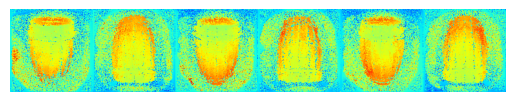

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm

depth_colormap = cm.jet(gt_images)  # This will produce an RGBA image
print(gt_images.shape, depth_colormap.shape)
# Remove the alpha channel
depth_colormap = depth_colormap[..., 0, :3]
plt.imsave('depth_colormap_birdman.png', depth_colormap)

# If you need to display the colorized depth map instead of saving it
plt.imshow(depth_colormap)
plt.axis('off')  # Disable axis
plt.show()

## Marigold 

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:

import tyro
import time
import random

import torch
from core.options import AllConfigs
from core.models_zero123plus import Zero123PlusGaussian, gt_attr_keys, start_indices, end_indices, fuse_splatters
from core.models_zero123plus_code import Zero123PlusGaussianCode
from core.models_zero123plus_code_unet_lora import Zero123PlusGaussianCodeUnetLora

from core.models_fix_pretrained import LGM

from accelerate import Accelerator, DistributedDataParallelKwargs
from safetensors.torch import load_file
from core.dataset_v4_batch import ObjaverseDataset as Dataset

import kiui
from datetime import datetime
import torch.utils.tensorboard as tensorboard
import shutil, os

from ipdb import set_trace as st
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import torch.nn.functional as F

import warnings
from accelerate.utils import broadcast
import re

import numpy
from PIL import Image
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler
# from zero123plus.img_to_mv_v3_my_decoder import to_rgb_image, unscale_image, unscale_latents

import einops
import rembg
import requests

from pytorch3d.transforms import quaternion_to_axis_angle, axis_angle_to_quaternion

/mnt/kostas-graid/sw/envs/xuyimeng/anaconda3/envs/lgm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/kostas-graid/sw/envs/xuyimeng/anaconda3/envs/lgm/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/xuyimeng/Repo/LGM/core/attention.py:22: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")


In [ ]:

def to_rgb_image(maybe_rgba: Image.Image):
    if maybe_rgba.mode == 'RGB':
        return maybe_rgba
    elif maybe_rgba.mode == 'RGBA':
        rgba = maybe_rgba
        img = numpy.random.randint(127, 128, size=[rgba.size[1], rgba.size[0], 3], dtype=numpy.uint8)
        img = Image.fromarray(img, 'RGB')
        img.paste(rgba, mask=rgba.getchannel('A'))
        return img
    else:
        raise ValueError("Unsupported image type.", maybe_rgba.mode)

def unscale_latents(latents):
    latents = latents / 0.75 + 0.22
    return latents

def unscale_image(image):
    image = image / 0.5 * 0.8
    return image

def scale_image(image):
    image = image * 0.5 / 0.8
    return image

def scale_latents(latents):
    latents = (latents - 0.22) * 0.75
    return latents

def normalize_to_target(source_tensor, target_tensor):
    # Calculate mean and standard deviation of source tensor
    source_mean = torch.mean(source_tensor)
    source_std = torch.std(source_tensor)

    # Calculate mean and standard deviation of target tensor
    target_mean = torch.mean(target_tensor)
    target_std = torch.std(target_tensor)

    # Normalize source tensor to target distribution
    normalized_tensor = (source_tensor - source_mean) / source_std * target_std + target_mean

    return normalized_tensor

def fuse_splatters(splatters):
    # fuse splatters
    B, V, C, H, W = splatters.shape

    x = splatters.permute(0, 1, 3, 4, 2).reshape(B, -1, 14)
    return x


### Config

In [ ]:
filtered_args = ["big"]
opt = tyro.cli(AllConfigs,  args=filtered_args)

from core.options import config_defaults
big_config = config_defaults['big']

# Now, big_config is an instance of Options with the 'big' configuration preset.
# You can use it directly or modify it as needed
big_config.num_epochs = 50  # Modify the number of epochs if needed
big_config.batch_size = 1  # Change the batch size if needed

print(opt)
# Merge the 'big' config with the parsed command-line arguments
for key, value in vars(opt).items():
    if hasattr(big_config, key) and value is not None:
        setattr(big_config, key, value)


## modify the command line args
DATA_DIR_BATCH_RENDERING='/mnt/kostas-graid/sw/envs/chenwang/workspace/lrm-zero123/assets/9000-9999'
DATA_DIR_BATCH_SPLATTER_GT_ROOT='/home/xuyimeng/Repo/LGM/runs/splatter_gt'

# Now modify opt based on the command line arguments
opt.workspace = "runs/zerp123plus_batch/workspace_inference2"
opt.lr = 2e-4
opt.num_epochs = 10001
opt.eval_iter = 5
opt.save_iter = 5
opt.lr_scheduler = "Plat"
opt.lr_scheduler_patience = 100
opt.lr_scheduler_factor = 0.7
opt.prob_cam_jitter = 0
opt.input_size = 320
opt.num_input_views = 6
opt.num_views = 20
opt.lambda_splatter = 0
opt.lambda_rendering = 1
opt.lambda_alpha = 0
opt.lambda_lpips = 0
opt.desc = "debug_encode_splatter"
opt.data_path_rendering = DATA_DIR_BATCH_RENDERING  # Replace with actual variable or constant
opt.data_path_splatter_gt = DATA_DIR_BATCH_SPLATTER_GT_ROOT  # Replace with actual variable or constant
opt.set_random_seed = True  # This implies there's some handling in the code to manage random seeds
opt.batch_size = 1
opt.num_workers = 1
opt.plot_attribute_histgram = ('scale',)  # Assuming this accepts a tuple of strings
opt.skip_predict_x0 = True
opt.scale_act = "biased_softplus"
opt.scale_act_bias = -3
opt.scale_bias_learnable = True
opt.scale_clamp_max = -2
opt.scale_clamp_min = -10
opt.model_type = "Zero123PlusGaussianCode"
opt.splatter_guidance_interval = 1
opt.save_train_pred = -1
opt.decode_splatter_to_128 = True
opt.decoder_upblocks_interpolate_mode = "last_layer"
opt.codes_from_diffusion = True
opt.vae_on_splatter_image = True


print(opt)


Options(input_size=256, down_channels=(64, 128, 256, 512, 1024, 1024), down_attention=(False, False, False, True, True, True), mid_attention=True, up_channels=(1024, 1024, 512, 256, 128), up_attention=(True, True, True, False, False), splat_size=128, output_size=512, data_mode='s3', fovy=49.1, znear=0.5, zfar=2.5, num_views=8, num_input_views=4, cam_radius=1.5, num_workers=8, workspace='./workspace', resume=None, batch_size=8, gradient_accumulation_steps=1, num_epochs=30, lambda_lpips=1.0, gradient_clip=1.0, mixed_precision='bf16', lr=0.0004, prob_grid_distortion=0.5, prob_cam_jitter=0.5, test_path=None, force_cuda_rast=False, fancy_video=False, fix_pretrained=False, eval_iter=100, save_iter=200, desc=None, data_path=None, model_type='Zero123PlusGaussian', model_path='sudo-ai/zero123plus-v1.1', custom_pipeline='./zero123plus/pipeline_v2.py', bg=0.5, lambda_rendering=1.0, lambda_splatter=1.0, lambda_alpha=1.0, lambda_kl=1e-06, train_unet=False, discard_small_opacities=False, render_gt_s

### Load diffusion pipeline

In [ ]:

model = Zero123PlusGaussianCode(opt)
from core.dataset_v4_code import ObjaverseDataset as Dataset

vae/diffusion_pytorch_model.safetensors not found
Loading pipeline components...:  12%|█▎        | 1/8 [00:00<00:06,  1.05it/s]/mnt/kostas-graid/sw/envs/xuyimeng/anaconda3/envs/lgm/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading pipeline components...: 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


opt.decoder_mode : v0_unfreeze_all
UNet Decoder vae.decoder requires grad: True
UNet Decoder others requires grad: True


RuntimeError: Only Tensors of floating point and complex dtype can require gradients

In [ ]:

from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler
# pipe = DiffusionPipeline.from_pretrained(
#         "sudo-ai/zero123plus-v1.1", custom_pipeline="/mnt/kostas-graid/sw/envs/chenwang/workspace/diffgan/training/modules/zero123plus.py",
#         torch_dtype=torch.float32
#     )
pipe = DiffusionPipeline.from_pretrained(
    "sudo-ai/zero123plus-v1.1", custom_pipeline="sudo-ai/zero123plus-pipeline",
    torch_dtype=torch.float16
)
pipe.to('cuda:0')
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(
    pipe.scheduler.config, timestep_spacing='trailing'
)
output_path = f"{opt.workspace}/zero123plus/outputs_v3_inference_my_decoder"
pipe.prepare()
guidance_scale = 4.0

vae/diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


In [ ]:
path = f"{DATA_DIR_BATCH_RENDERING}/ffb0d644238b4c679658aa0ee46ac6da"
path

'/mnt/kostas-graid/sw/envs/chenwang/workspace/lrm-zero123/assets/9000-9999/ffb0d644238b4c679658aa0ee46ac6da'

In [ ]:

poses = [np.load(f'{path}/{i:03d}.npy', allow_pickle=True).item() for i in range(1, 56)]
elevations, azimuths = [-pose['elevation'] for pose in poses], [pose['azimuth'] for pose in poses]
# imgs = [np.array(Image.open(f'{path}/{i:03d}.png')) / 255.0 for i in range(1, 7)]
# imgs = [img[..., :3] * img[..., 3:4] + (1 - img[..., 3:4]) for img in imgs]

# get imgs from pipeline
cond = Image.open(f'{path}/{0:03d}.png')

In [98]:

result = pipe(cond, num_inference_steps=75).images[0]

from torchvision import transforms
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

# Normalization typically required for pre-trained models
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Combine ToTensor and Normalize transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # normalize
])

image = transform(result) # 3, 960, 640
mv_image = einops.rearrange((image.clip(0,1)).cpu().numpy()*255, 'c (h2 h) (w2 w)-> (h2 w2) h w c', h2=3, w2=2).astype(np.uint8)

100%|██████████| 75/75 [00:06<00:00, 11.44it/s]


In [ ]:
def prepare_default_rays( device, elevation, azimuth):
        
    from kiui.cam import orbit_camera
    from core.utils import get_rays

    # cam_poses = np.stack([
    #     orbit_camera(-30, 30, radius=self.opt.cam_radius),
    #     orbit_camera(20, 90, radius=self.opt.cam_radius),
    #     orbit_camera(-30, 150, radius=self.opt.cam_radius),
    #     orbit_camera(20, 210, radius=self.opt.cam_radius),
    #     orbit_camera(-30, 270, radius=self.opt.cam_radius),
    #     orbit_camera(20, 330, radius=self.opt.cam_radius),
    # ], axis=0) # [4, 4, 4]
    cams = [orbit_camera(ele, azi, radius=opt.cam_radius) for (ele, azi) in zip(elevation, azimuth)]
    cam_poses = np.stack(cams, axis=0)
    cam_poses = torch.from_numpy(cam_poses)

    rays_embeddings = []
    for i in range(cam_poses.shape[0]):
        rays_o, rays_d = get_rays(cam_poses[i], opt.input_size, opt.input_size, opt.fovy) # [h, w, 3]
        rays_plucker = torch.cat([torch.cross(rays_o, rays_d, dim=-1), rays_d], dim=-1) # [h, w, 6]
        rays_embeddings.append(rays_plucker)

        ## visualize rays for plotting figure
        # kiui.vis.plot_image(rays_d * 0.5 + 0.5, save=True)

    rays_embeddings = torch.stack(rays_embeddings, dim=0).permute(0, 3, 1, 2).contiguous().to(device) # [V, 6, h, w]
    
    return rays_embeddings


input_image = torch.from_numpy(mv_image).permute(0, 3, 1, 2).float().to(pipe.device) # [4, 3, 256, 256]
input_image = F.interpolate(input_image, size=(opt.input_size, opt.input_size), mode='bilinear', align_corners=False)
# if opt.model_type == 'LGM':
#     rays_embeddings = model.prepare_default_rays(device, elevations[:6], azimuths[:6])
#     input_image = TF.normalize(input_image, IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
#     input_image = torch.cat([input_image, rays_embeddings], dim=1).unsqueeze(0) # [1, 4, 9, H, W]
rays_embeddings = prepare_default_rays(pipe.device, elevations[:6], azimuths[:6])
input_image = torch.cat([input_image, rays_embeddings], dim=1).unsqueeze(0) # [1, 4, 9, H, W]


In [44]:
from scipy.stats import mode
mode_result = mode(mv_image[0].reshape(-1,3))


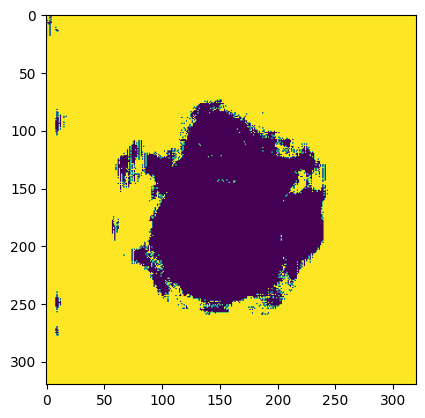

In [97]:
mode_result.mode + 1

# # remok.sve bg
# bg_mask_1 = np.all(mode_result.mode == mv_image[0], axis=-1) 
# bg_mask_2 = np.all((mode_result.mode + 1) == mv_image[0], axis=-1)
# # bg_mask = np.any(bg_mask_1 or bg_mask_2)
# bg_mask = (bg_mask_1 + bg_mask_2).clip(0,1)
# # bg_mask.shape, bg_mask.astype(np.uint8)

half_img = (mv_image[0].astype(np.float32) / 2. ).round().astype(np.uint8)
bg_mask = np.all(64 == half_img, axis=-1) 
# bg_mask_2 = np.all((mode_result.mode + 1) == mv_image[0], axis=-1)
plt.imshow(bg_mask)


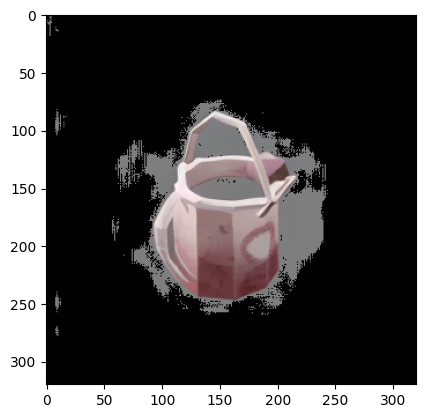

In [94]:
import matplotlib.pyplot as plt

plt.imshow(mv_image[0])
plt.imshow(bg_mask.astype(np.uint8)*255)

img_no_bg = mv_image[0] * (1 - bg_mask[...,None]) + bg_mask[...,None]
plt.imshow(img_no_bg)

In [106]:
mv_image_no_bg = rembg.remove(einops.rearrange(mv_image, 'b h w c -> h (b w) c')) # .astype(np.float32) / 255.

2024-04-13 19:16:20.126551086 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 274711, index: 0, mask: {1, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2024-04-13 19:16:20.126558426 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 274712, index: 1, mask: {2, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2024-04-13 19:16:20.126598976 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 274713, index: 2, mask: {3, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2024-04-13 19:16:20.126614566 [E:onnxruntime:Default, env.cc:254 ThreadMain] pthread_setaffinity_np failed for thread: 274714, index: 3, mask: {4, }, error code: 22 error msg: Invalid argument. Specify the numbe

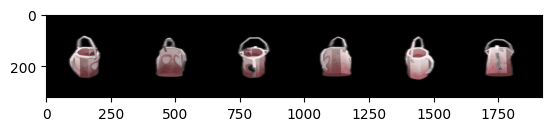

In [111]:
# plt.imshow(img_no_bg)
# np.array([3.6]).round().astype(np.uint8)
plt.imshow(mv_image_no_bg[...,:-1])
# plt.imshow(einops.rearrange(mv_image, 'b h w c -> h (b w) c'))

In [116]:
mv_image_no_bg.shape
mask = mv_image_no_bg[..., -1] > 0

# from kiui.op import recenter
# # recenter
# image = recenter(mv_image_no_bg, mask, border_ratio=0.2)

# generate mv
# image = image.astype(np.float32) / 255.0
image = mv_image_no_bg.astype(np.float32) / 255.0

### Load dataset

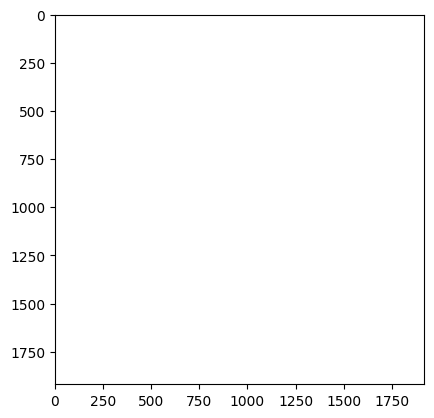

In [117]:
plt.imshow(image)

### 1. Bad init from LGM output

In [115]:
image.shape, mv_image_no_bg.shape

((1920, 1920, 4), (320, 1920, 4))

### 2. Fake init from RGB + depth + constant others